## Turial 0 : Bring Your Own Graphs

### Mathematical definition of graphs

A graph is a structure amounting to a set of objects where some objects are "related." The objects are often referred to as 'nodes' (or vertices), and the related pairs of vertices refer to as 'edges' (or lines). Mathematically speaking, there's no one unified framework for describing the graph. In this series of tutorials, we represent a graph as a tuple:

$$\mathcal{G}=<V,A>$$

where the $V$ is the set of vertices, and $A$ is the adjacency matrix. The columns and rows indicate nodes. If the value of $A_{ij}$ is 1, then the edge exists between two nodes $i,j$. For the undirected graphs, the adjacent $A$ is symmetric.

We can expand this setup to the directed graphs where the edges are directed. Depending on the edge's direction, the source node is the node where the edge starts from, and the destination node is the node where the edge reaches. In the directed graphs, the adjacent matrix $A$ can be asymmetric.

Note that the index of nodes (and the edges) are arbitrary. This property becomes important in the computational process of GNN, namely permutations invariance.

## Instantiating a graph in python

In python, we have a couple of ways to build graphs. We focus on `networkx` and `PyG` for this purpose.

`networkx` is one of the basic packages for handling graph format data in python. Hence almost every major graph-related packages have an interface to convert a framework-specific graph to the `networkx` equivalent one.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

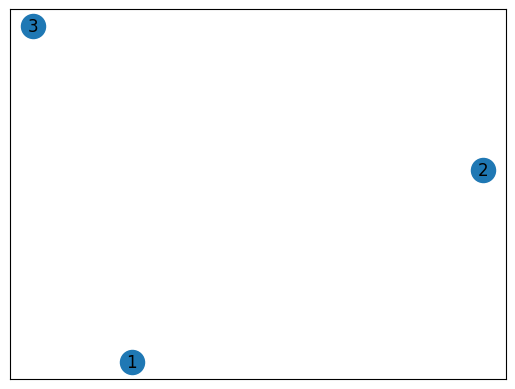

In [2]:
G = nx.Graph() # instantiate an empty container for handling graph
G.add_node(1) # Add node in the graph
G.add_node(2) # Add node in the graph
G.add_node(3) # Add node in the graph
nx.draw_networkx(G)

let's add some edges to the graph `G`

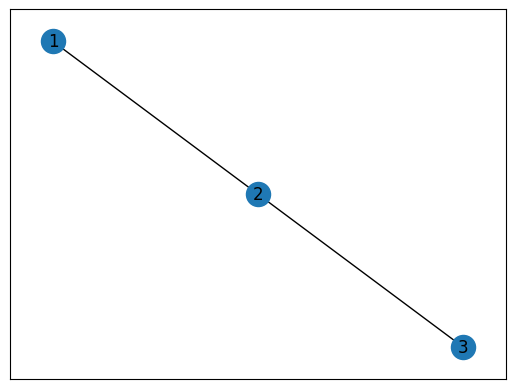

In [3]:
G.add_edge(1,2)
G.add_edge(2,3)
nx.draw_networkx(G)

## PyG as a computational framework over graphs

Even though `networkx` supports a unified way for handling graphs in python, it is not friendly with the computations. This section mathematically defines the attributed graphs where the nodes (or/and) edges have the attributes and handling such attributed graphs in `PyG`.

The attributed graph $\mathcal{G}$ is often defined as follows:
$$\mathcal{G} = <V, E>$$

where the $V$ is the **set** of node-related features (node features), and $E$ is the **set** of edge-related features (edge features). Assume the adjacency matrix $A$ is defined implicitly.

We often assume all the node features for all nodes have the same feature dimensions for the simplicity of computations. Similarly, we put the same assumption on the edge features. 

In practice, we achieve such assumptions easily. In some applications, different nodes may be of different types. As a result, different nodes may have different input features. However, by appending some proper dimensional vectors in the front or last, we can treat them to be the same dimensional vectors.

Let's instanitate an attributed graph with `PyG`.

In [4]:
import torch_geometric as pyg
from torch_geometric.data import Data
import torch

In [5]:
num_nodes = 4
node_feat_dim = 9
edge_feat_dim = 7

In [6]:
# Node features
x = torch.randint(size=(num_nodes, node_feat_dim), high=3) # [num_nodes, node_feat_dim]

# edges 0->1, 0->2, 0->3, 1->3, 2->1
u, v = torch.tensor([0, 0, 0, 1, 2]), torch.tensor([1, 2, 3, 3, 1])
edge_index = torch.stack([u, v], dim=0) # [2, num_edges]
num_edges = edge_index.shape[1]

# Edge featurs
edge_attr = torch.randn(size=(edge_index.shape[1], 
                              edge_feat_dim)) # [num_edges, edge_feat_dim]


g = Data(x=x, # node feature matrix
         edge_index=edge_index,
         edge_attr=edge_attr)
print(g)

Data(x=[4, 9], edge_index=[2, 5], edge_attr=[5, 7])


## Querying attributes of graph

We've assigned the node features as `x` and edge features as `edge_attr` to the graph `G`. We can access them as follows:

In [7]:
print(f"Node features \n size: {g.x.shape} \n values: \n {g.x}") # equivalently g['x']

print(f"Edge features: \n size: {g.edge_attr.shape} \n values: \n {g.edge_attr}")


Node features 
 size: torch.Size([4, 9]) 
 values: 
 tensor([[0, 2, 1, 2, 1, 0, 1, 0, 1],
        [0, 2, 2, 1, 2, 1, 2, 0, 1],
        [0, 2, 0, 1, 2, 2, 2, 2, 1],
        [1, 1, 1, 0, 0, 0, 2, 0, 0]])
Edge features: 
 size: torch.Size([5, 7]) 
 values: 
 tensor([[ 1.0233, -1.1840,  0.4206, -0.7128, -1.0163,  1.6416, -0.6705],
        [-0.0669, -1.2146,  1.3727, -1.3669, -1.0359, -1.2729, -1.0455],
        [ 0.1603,  0.3101,  0.3133, -0.1821, -1.2238,  0.2336, -0.0300],
        [-0.0083, -0.0791, -1.0867, -0.4457,  0.0684, -0.0316,  0.6021],
        [ 0.4912,  0.0161, -0.1198, -0.2523, -0.7841, -1.1474, -0.1157]])


## Querying the structure of the graph

When it comes to implementing GNN, querying the statistics of graph, such as number of nodes, edges, and the degree of nodes, are often required. In this section, we will see how to query the graph structure with `PyG`.


In [8]:
# number of nodes in the graph
print(f"Number of Nodes: {g.num_nodes}")

# number of edge in the graph
print(f"Number of edges: {g.num_edges}")

# node feature dimension
print(f"Node feature dimension: {g.num_node_features}")

# edge feature dimension
print(f"Edge feature dimension: {g.num_edge_features}")

Number of Nodes: 4
Number of edges: 5
Node feature dimension: 9
Edge feature dimension: 7


## Assigning arbitrary attributes to the graph

From time to time, we may want to store additional information to the graph. For example, the prediction label of the graph, or the graph-level features In this section, we will see how to assign arbitrary attributes to the graph with `PyG`.

In [9]:
g = Data(x=x, # node feature matrix
         edge_index=edge_index,
         edge_attr=edge_attr,
         y_node=torch.randn(size=(num_nodes, 1)), # node label
         y_graph=torch.randn(size=(1, 1)), # graph label       
         )
print(g)

Data(x=[4, 9], edge_index=[2, 5], edge_attr=[5, 7], y_node=[4, 1], y_graph=[1, 1])


In [10]:
print(g.y_node)

tensor([[-1.2283],
        [-0.3237],
        [ 0.1174],
        [ 0.0475]])


## Device control of `Data` object

In pytorch, we can move the data to the GPU by calling `to` method. In `PyG`, we can do the same thing by calling `to` method. In this section, we will see how to move the `Data` object to the GPU.

In [11]:
# Move the graph to CPU
g = g.to('cpu')
print(g.x.device)

# Move the graph to GPU
g = g.to('cuda:0') # Move the graph to the first CUDA device -- i.e., GPU 0
print(g.x.device)

cpu
cuda:0


More detailed explanation of `Data` can be found from the official documentation of [link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)

## Batching graph with `Batch`

Unlike tensor-based data, graph-based data has a variable size of the graph. 
Due to this structural differences, conventional way of batching -- i.e., compile the tensors over the new axis -- is not applicable to the graph-based data. Instead, graphs are batched with one big (disconnected) graph. In this section, we will see how to batch the graph with `Batch` object.

In [12]:
def generate_random_graph(num_node: int, 
                          p_edges: float=0.1,
                          node_feat_dim: int=3,
                          edge_feat_dim: int=5):
    
    x = torch.randn(size=(num_node, node_feat_dim))
    # assume directional and potentially self-loop
    num_edges = int(num_node * num_node * p_edges)
    
    edge_index = torch.stack([torch.arange(num_node).repeat(num_node),
                              torch.arange(num_node).repeat(num_node)], dim=0)
    edge_index = edge_index[:, torch.randperm(edge_index.shape[1])]
    edge_index = edge_index[:, :num_edges]
    
    edge_attr = torch.randn(size=(num_edges, edge_feat_dim))
    
    dummy_attr = torch.randn(size=(num_node, 1))
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
                dummy_attr=dummy_attr)

In [13]:
num_gs = 4
num_nodes = [7, 8, 5, 11]

gs = [generate_random_graph(num_node=num_node) for num_node in num_nodes]
for i, g in enumerate(gs):
    print(f"Graph {i+1}: {g}")

Graph 1: Data(x=[7, 3], edge_index=[2, 4], edge_attr=[4, 5], dummy_attr=[7, 1])
Graph 2: Data(x=[8, 3], edge_index=[2, 6], edge_attr=[6, 5], dummy_attr=[8, 1])
Graph 3: Data(x=[5, 3], edge_index=[2, 2], edge_attr=[2, 5], dummy_attr=[5, 1])
Graph 4: Data(x=[11, 3], edge_index=[2, 12], edge_attr=[12, 5], dummy_attr=[11, 1])


In [22]:
batched_g = Batch.from_data_list(gs, 
                                 exclude_keys=['dummy_attr'])
print(type(batched_g)) # Batch is a subclass of Data -- this explains so much!)
print(batched_g)

<class 'torch_geometric.data.batch.DataBatch'>
DataBatch(x=[31, 3], edge_index=[2, 24], edge_attr=[24, 5], batch=[31], ptr=[5])


## Querying the batched graph statistics

In [23]:
print(f"Number of batched graphs: {batched_g.num_graphs}")
print(f"Number of cumulative nodes: {batched_g.ptr}")
print(f"Batch indicators: {batched_g.batch}")

Number of batched graphs: 4
Number of cumulative nodes: tensor([ 0,  7, 15, 20, 31])
Batch indicators: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])
